# **Создание модели рекомендательной системы**

**Задача**

В группе компаний Тинькофф есть команда edTech, создающая платформу для обучающих курсов.
У команды edTech возникает вопрос, а какие курсы сильнее всего влияют на рабочие показатели сотрудников в колл-центре.
Помогите составить рекомендации, какие обучающие курсы стоит проходить сотрудникам, а какие курсы стоит убрать с edTech платформы.
Решение может быть как рекомендательной моделью для каждого из сотрудников, так и основано на бизнес-правилах и статистическом анализе (например, выделить для каждого департамента полезные курсы).

**Потенциальное решение**

Предполагается, что решение будет выполнено на Python, будет итоговая презентация. Решение может содержать блоки: эксплораторный анализ, Causal Inference методы, рекомендательную модель.
Ограничений на подход к решению нет, но для определения важности курсов советуем использовать методы анализа причинности. Подробнее можно почитать о них [здесь,](https://koch-kir.medium.com/causal-inference-from-observational-data-%D0%B8%D0%BB%D0%B8-%D0%BA%D0%B0%D0%BA-%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%81%D1%82%D0%B8-%D0%B0-%D0%B2-%D1%82%D0%B5%D1%81%D1%82-%D0%B1%D0%B5%D0%B7-%D0%B0-%D0%B2-%D1%82%D0%B5%D1%81%D1%82%D0%B0-afb84f2579f2) а также возможна консультация со стороны организаторов.

# **Описание таблиц**

**employees**

Информация о сотрудниках колл-центра
Поля:
- employee_id - идентификатор сотрудника
- sex – пол
- region - идентификатор федерального округа
- age – возраст
- head_employee_id – идентификатор руководителя
- exp_days – опыт в днях
- edu_degree – уровень образования
- department_id – индентификатор департамента, в котором работает сотрудник
- work_online_flg – флаг работы на удалённом режиме

**communications**

Информация о рабочих показателях сотрудников. Рассматривались рабочие коммункации операторов колл-центра
Поля:
- communication_id – идентификатор коммуникации
- communication_dt – дата коммуникации
- employee_id - идентификатор сотрудника
- communication_score – оценка качества коммуникации
- util_flg – флаг того, что клиент воспользовался банковским продуктом в течение 2 недель

**courses_passing**

Статиситка прохождения обучающих курсов сотрудниками
- course_id – идентификатор курса
- employee_id - идентификатор сотрудника
- pass_frac – доля прохождения курса
- start_dt – дата начала прохождения
- last_activity_dt – последняя активность сотрудника в обучающем курсе
- end_dt – дата окончания обучения. Если обучение пройдено не полностью, то NaN
- educ_duration_days – длительность полного обучения в днях. Если обучение пройдено не полностью, то NaN

**courses_info**

Информация о курсах
- course_id – идентификатор курса
- course_nm – название курса

**course_employee_sms**

Сводная таблица с нотификациями сотрудникам с предложением пройти обучение. Нотификации рассылались случайным образом
Поля:
- employee_id - идентификатор сотрудника
- course_i – флаг наличия нотификации

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Установка опции для отображения нормальных чисел
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Объединие таблиц в один датасет

Решили оставить создание итогового датасета, так как его загрузка и сохранение занмиает значительное количество времени. 
Сохраним все этапы создания `full_data.csv`.

Загризим все датасеты

In [4]:
# Загрузим датасет
communications = pd.read_csv('../data/src/communications.csv', sep=';', dtype={'employee_id': 'category'})
courses_passing = pd.read_csv('../data/src/courses_passing.csv', sep=';',  dtype={'employee_id': 'category'})
employees = pd.read_csv('../data/src/employees.csv', sep=';', dtype={'employee_id': 'category', 'head_employee_id': 'category', 'sex': 'category'})
course_employee_sms = pd.read_csv('../data/src/course_employee_sms.csv', sep=';')
courses_info = pd.read_csv('../data/src/courses_info.csv', sep=';')

In [5]:
# Измененим типов данных некоторых столбцов
communications['communication_dt'] = pd.to_datetime(communications['communication_dt'])

Начнем с объединения таблиц `employees` и `communications`. В качестве ключа используем `employee_id` 

In [6]:
# Объединение данных
combined_data = pd.merge(employees, communications, on='employee_id', how='inner')

Тут надо скорректировать типы данных:

In [7]:
# Преобразование pass_frac в булев тип
courses_passing['pass_frac'] = courses_passing['pass_frac'] > 0

In [8]:
# Сначала заменим NaN на 0, затем преобразуем в int
courses_passing['educ_duration_days'] = courses_passing['educ_duration_days'].fillna(0).astype(int)

In [9]:
# Преобразование строковых дат в datetime формат
courses_passing['start_dt'] = pd.to_datetime(courses_passing['start_dt'])
courses_passing['last_activity_dt'] = pd.to_datetime(courses_passing['last_activity_dt'])
courses_passing['end_dt'] = pd.to_datetime(courses_passing['end_dt'])

Теперь объединим таблицы `combined_data` и `courses_passing`

In [10]:
# Объединение combined_data с информацией о курсах
full_data = pd.merge(combined_data, courses_passing, on='employee_id', how='left')

In [11]:
del combined_data

## Обработка полученного датасета

Обработаем пропуски в датасете `full_data`

In [12]:
# Замена NaN в 'end_dt' и 'educ_duration_days'
full_data['end_dt'] = pd.to_datetime(full_data['end_dt'], errors='coerce')  # Преобразование в datetime, невалидные значения станут NaT
full_data['educ_duration_days'] = full_data['educ_duration_days'].fillna(0).astype(int)  # Замена NaN на 0 и преобразование в int

Теперь проверим нормализацию дат

In [13]:
# Убедимся, что все столбцы с датами имеют тип datetime
date_columns = ['communication_dt', 'start_dt', 'last_activity_dt', 'end_dt']
for col in date_columns:
    full_data[col] = pd.to_datetime(full_data[col], errors='coerce')  # Преобразование в datetime, невалидные значения станут NaT

In [14]:
# Проверка результатов
print(full_data[date_columns].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26020279 entries, 0 to 26020278
Data columns (total 4 columns):
 #   Column            Dtype         
---  ------            -----         
 0   communication_dt  datetime64[ns]
 1   start_dt          datetime64[ns]
 2   last_activity_dt  datetime64[ns]
 3   end_dt            datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 794.1 MB
None


`Обработка пропущенных значений:` В `educ_duration_days` пропущенные значения заменяются на 0, что может быть интерпретировано как отсутствие завершения курса. В `end_dt` используется pd.to_datetime с errors='coerce', что преобразует некорректные или отсутствующие значения в NaT (Not a Time), что является аналогом NaN для временных данных.

`Нормализация дат:` Для каждого столбца с датами применяется pd.to_datetime для гарантии того, что все данные в этих столбцах будут иметь тип datetime64[ns], что обеспечивает унификацию формата и упрощает последующий анализ.

In [15]:
# Создание временных признаков
full_data['time_since_last_activity'] = (full_data['communication_dt'] - full_data['last_activity_dt']).dt.days
full_data['time_since_end'] = (full_data['communication_dt'] - full_data['end_dt']).dt.days.fillna(0)

In [16]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26020279 entries, 0 to 26020278
Data columns (total 21 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   employee_id               object        
 1   sex                       category      
 2   region                    int64         
 3   age                       int64         
 4   head_employee_id          category      
 5   exp_days                  int64         
 6   edu_degree                int64         
 7   department_id             int64         
 8   work_online_flg           int64         
 9   communication_id          int64         
 10  communication_dt          datetime64[ns]
 11  communication_score       int64         
 12  util_flg                  int64         
 13  course_id                 float64       
 14  pass_frac                 object        
 15  start_dt                  datetime64[ns]
 16  last_activity_dt          datetime64[ns]
 17  end_dt

In [17]:
# Предлагаю считать оценку разговора по следующей формуле
full_data['weighted_mark'] = \
    full_data['util_flg'] * 100 * 0.5 \
    + full_data['communication_score'] * 0.5
# Так мы учтём влияние прихода клиента в общей оценке,
# как немаловажный показатель эффективности труда.

Отсортируем по дате и удалим пропуски по столбцу `course_id`

In [18]:
# Отсортируем данные
full_data_sorted = full_data.sort_values(by=['communication_dt', 'start_dt'])

In [20]:
full_data_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26020279 entries, 544976 to 26020159
Data columns (total 22 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   employee_id               object        
 1   sex                       category      
 2   region                    int64         
 3   age                       int64         
 4   head_employee_id          category      
 5   exp_days                  int64         
 6   edu_degree                int64         
 7   department_id             int64         
 8   work_online_flg           int64         
 9   communication_id          int64         
 10  communication_dt          datetime64[ns]
 11  communication_score       int64         
 12  util_flg                  int64         
 13  course_id                 float64       
 14  pass_frac                 object        
 15  start_dt                  datetime64[ns]
 16  last_activity_dt          datetime64[ns]
 17  end_dt

In [ ]:
# Удалим лишние столбцы
full_data_sorted = full_data_sorted.drop(columns=['head_employee_id','communication_id','communication_score','util_flg','start_dt','last_activity_dt','end_dt','educ_duration_days'])

In [23]:
full_data_sorted.head()

,employee_id,sex,region,age,exp_days,edu_degree,department_id,work_online_flg,communication_dt,course_id,pass_frac,time_since_last_activity,time_since_end,weighted_mark
544976,e21e4e58-ad9a-b56e-8a46-34046da90113,F,3,23,272,2,2,0,2023-01-01,76.00,True,-18.00,-18.00,36.50
545680,e21e4e58-ad9a-b56e-8a46-34046da90113,F,3,23,272,2,2,0,2023-01-01,76.00,True,-18.00,-18.00,50.00
557632,e21e4e58-ad9a-b56e-8a46-34046da90113,F,3,23,272,2,2,0,2023-01-01,76.00,True,-18.00,-18.00,93.00
561296,e21e4e58-ad9a-b56e-8a46-34046da90113,F,3,23,272,2,2,0,2023-01-01,76.00,True,-18.00,-18.00,100.00
564352,e21e4e58-ad9a-b56e-8a46-34046da90113,F,3,23,272,2,2,0,2023-01-01,76.00,True,-18.00,-18.00,67.00


In [24]:
# Посмотрим количество пропусков
full_data_sorted.isna().sum()

employee_id                       0
sex                               0
region                            0
age                               0
exp_days                          0
edu_degree                        0
department_id                     0
work_online_flg                   0
communication_dt                  0
course_id                   1395481
pass_frac                   1395481
time_since_last_activity    1395481
time_since_end                    0
weighted_mark                     0
dtype: int64

In [25]:
# Удаляем строки с пропусками в столбце 'course_id'
full_data_sorted = full_data_sorted.dropna(subset=['course_id'])

Обработаем пропуски еще в столбце `end_dt` заполнив их текущей датой

In [27]:
# Заполнение пропусков в course_id специальным значением, например -1
#full_data_sorted['course_id'].fillna(-1, inplace=True)

# Заполнение пропусков в pass_frac нулем
#full_data_sorted['pass_frac'].fillna(0, inplace=True)

# Заполнение пропусков в start_dt и last_activity_dt текущей датой или другой логичной датой
# Важно убедиться, что это логично для вашей задачи
current_date = pd.Timestamp('today')
#full_data_sorted['start_dt'].fillna(current_date, inplace=True)
#full_data_sorted['last_activity_dt'].fillna(current_date, inplace=True)

# Если end_dt должно указывать на продолжающееся обучение, можно использовать текущую дату
#full_data_sorted['end_dt'].fillna(current_date, inplace=True)

# Если есть логика заполнения time_since_last_activity, например разницей между текущей датой и last_activity_dt
#full_data_sorted['time_since_last_activity'] = full_data_sorted['time_since_last_activity'].fillna(
#    (current_date - full_data_sorted['last_activity_dt']).dt.days
#)

# Вывод количества пропущенных значений после обработки
print(full_data_sorted.isna().sum())

employee_id                 0
sex                         0
region                      0
age                         0
exp_days                    0
edu_degree                  0
department_id               0
work_online_flg             0
communication_dt            0
course_id                   0
pass_frac                   0
time_since_last_activity    0
time_since_end              0
weighted_mark               0
dtype: int64


Видим что теперь пропусков теперь нет.

Теперь разделим датасет на два периода и закодируем столбцы `employee_id`, `course_id`

In [30]:
# Определение точки разделения (например, 80% данных для обучения)
split_index = int(len(full_data_sorted) * 0.8)

# Создание тренировочного и тестового наборов
train_data = full_data_sorted.iloc[:split_index]
test_data = full_data_sorted.iloc[split_index:]

In [31]:
# Создание экземпляра LabelEncoder
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Кодирование пользовательских и курсовых ID в непрерывные целочисленные значения
train_data['encoded_employee_id'] = user_encoder.fit_transform(train_data['employee_id'])
train_data['encoded_course_id'] = item_encoder.fit_transform(train_data['course_id'])

# Повторите эти шаги для тестовых данных, используя те же кодировщики (fit не нужен)
test_data['encoded_employee_id'] = user_encoder.transform(test_data['employee_id'])
test_data['encoded_course_id'] = item_encoder.transform(test_data['course_id'])

## Создание модели с коллаборативной фильтрацией

Для коллаборативной фильтрации можно использовать оценки сотрудников, например, `communication_score` и учет прохождения курсов, чтобы рекомендовать курсы, которые проходили сотрудники с похожими рабочими результатами. Попробуем обучить модель с помощью GPU  с помощью PyTorch:

In [34]:
class CFData(Dataset):
    def __init__(self, dataframe):
        """
        Конструктор класса CFData.
        
        Args:
            dataframe (DataFrame): Входной DataFrame с данными.
        """
        # Создаем тензоры для пользователей, элементов и рейтингов из DataFrame
        self.users = torch.tensor(dataframe['encoded_employee_id'].values, dtype=torch.int64)
        self.items = torch.tensor(dataframe['encoded_course_id'].values, dtype=torch.int64)
        self.ratings = torch.tensor(dataframe['weighted_mark'].values, dtype=torch.float32)

    def __len__(self):
        """
        Возвращает общее количество элементов в наборе данных.
        
        Returns:
            int: Общее количество элементов.
        """
        return len(self.ratings)

    def __getitem__(self, idx):
        """
        Получает элементы из набора данных по заданному индексу.
        
        Args:
            idx (int): Индекс элемента.
        
        Returns:
            tuple: Кортеж, содержащий данные о пользователе, элементе и рейтинге.
        """
        # Получаем данные о пользователе, элементе и рейтинге по заданному индексу
        return self.users[idx], self.items[idx], self.ratings[idx]

In [35]:
# Создание экземпляра PyTorch Dataset для обучающих данных
train_dataset = CFData(train_data)

# Создание DataLoader для обучающего набора данных
# batch_size - количество элементов в одном батче
# shuffle - указывает, следует ли перемешивать данные перед каждой эпохой
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [36]:
# Определение модели SVD (Singular Value Decomposition)
class SVDModel(nn.Module):
    def __init__(self, n_users, n_items, n_factors=100):
        """
        Конструктор класса SVDModel.
        
        Args:
            n_users (int): Количество пользователей.
            n_items (int): Количество элементов.
            n_factors (int, optional): Количество скрытых факторов.
        """
        super(SVDModel, self).__init__()
        
        # Определение вложений (embeddings) для пользователей и элементов
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        """
        Прямой проход модели.
        
        Args:
            user (Tensor): Идентификаторы пользователей.
            item (Tensor): Идентификаторы элементов.
        
        Returns:
            Tensor: Прогнозы модели.
        """
        # Получаем вложения для пользователей и элементов
        user_embedding = self.user_factors(user)
        item_embedding = self.item_factors(item)
        
        # Произведение поэлементное, затем суммируем по второй оси (оси скрытых факторов)
        dot_product = (user_embedding * item_embedding).sum(1)
        return dot_product

In [37]:
# Инициализация модели
n_users = full_data_sorted['employee_id'].nunique()
n_items = full_data_sorted['course_id'].nunique()
# Создание экземпляра модели SVD и перенос его на GPU
model = SVDModel(n_users, n_items).to('cuda') 

In [38]:
# Определение оптимизатора и функции потерь
optimizer = optim.AdamW(model.parameters(), lr=0.01)  # Оптимизатор Adam с коэффициентом скорости обучения 0.01
criterion = nn.MSELoss()  # Функция потерь Mean Squared Error (MSE)

In [39]:
print(f'Максимальный user ID: {train_data.encoded_employee_id.max()}, Количество of users: {n_users}')
print(f'Максимальный course ID: {train_data.encoded_course_id.max()}, Количество of courses: {n_items}')

Максимальный user ID: 1757, Количество of users: 1758
Максимальный course ID: 91, Количество of courses: 92


In [49]:
model.train()  # Установка модели в режим обучения
for epoch in range(10):
    for users, items, ratings in train_loader:
        users, items, ratings = users.to('cuda'), items.to('cuda'), ratings.to('cuda')  # Перенос данных на GPU
        optimizer.zero_grad()  # Обнуление градиентов
        outputs = model(users, items)  # Получение выходных данных модели
        loss = criterion(outputs, ratings)  # Вычисление потерь
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновление параметров модели
    print(f'Epoch {epoch+1}, Loss: {loss.item()}') 

Epoch 1, Loss: 1151.5845947265625
Epoch 2, Loss: 1101.0458984375
Epoch 3, Loss: 1091.6390380859375
Epoch 4, Loss: 1103.8612060546875
Epoch 5, Loss: 1343.900390625
Epoch 6, Loss: 1238.0576171875
Epoch 7, Loss: 1094.9918212890625
Epoch 8, Loss: 1060.9107666015625
Epoch 9, Loss: 957.3785400390625
Epoch 10, Loss: 969.2355346679688


In [50]:
# Сохранение модели
torch.save(model, '..\models\model_v1.pth')

In [51]:
# Загрузка модели
model = torch.load('..\models\model_v1.pth')
model.eval()

SVDModel(
  (user_factors): Embedding(1758, 100)
  (item_factors): Embedding(92, 100)
)

In [52]:
# Проверим прогнозирование рекомендаций на тестовых данных
predict_dataset = CFData(test_data)
predict_loader = DataLoader(predict_dataset, batch_size=512, shuffle=False)

In [53]:
# Перевод модели в режим оценки
model.eval()

# Список для хранения предсказаний
predictions = []

with torch.no_grad():  # Выключение расчета градиентов для ускорения
    for users, items, _ in predict_loader:
        users, items = users.to('cuda'), items.to('cuda')
        outputs = model(users, items)
        predictions.extend(outputs.cpu().numpy())  # Перемещение предсказаний на CPU и преобразование в numpy array

# Сохранение предсказаний обратно в DataFrame
test_data['predicted_score'] = predictions

In [54]:
# Удалим дубликаты
top_n_recommendations = test_data.drop_duplicates(subset=['employee_id', 'course_id'])

# Объединение DataFrame с информацией о рекомендациях и курсах
final_recommendations = top_n_recommendations.merge(courses_info, on='course_id', how='left')

In [55]:
# Выбор топ-5 уникальных курсов для каждого сотрудника
top_n_recommendations = final_recommendations.sort_values(by=['employee_id', 'predicted_score'], ascending=[True, False]).groupby('employee_id').head(5)

# Показать результаты
top_n_recommendations[['employee_id', 'course_id', 'course_nm', 'predicted_score']].head(30)

,employee_id,course_id,course_nm,predicted_score
10407,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,8.00,Развитие навыков эмпатии в клиентском обслужив...,73.96
10294,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,20.00,Основы психологии клиентского обслуживания,72.45
10539,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,50.00,Эффективное планирование и организация работы ...,70.96
9780,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,7.00,Построение долгосрочных отношений с клиентами:...,70.95
10274,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,29.00,Использование эмоционального интеллекта в обще...,70.05
4722,006f52e9-102a-8d3b-e2fe-5614f42ba989,51.00,Разработка персонализированных подходов к обсл...,70.78
4060,006f52e9-102a-8d3b-e2fe-5614f42ba989,19.00,Современные тенденции в клиентском сервисе: Ан...,69.34
2861,006f52e9-102a-8d3b-e2fe-5614f42ba989,10.00,Использование технологий в клиентском обслужив...,69.09
5922,006f52e9-102a-8d3b-e2fe-5614f42ba989,81.00,Развитие навыков переговоров и конфликтного ра...,68.73
2819,006f52e9-102a-8d3b-e2fe-5614f42ba989,8.00,Развитие навыков эмпатии в клиентском обслужив...,68.43


In [56]:
# Сохраним данные
top_n_recommendations.to_csv('top_n_recommendations.csv')

## Анализ полученных результатов

Проанализируем полученные результаты следующим образом:
1. **Анализ Распределения Оценок** - это поможет нам увидеть, как распределены предсказанные оценки среди рекомендованных курсов. Мы можем построить гистограмму, чтобы визуализировать это распределение.
2. **Анализ Частоты Рекомендаций Курсов**. Мы можем проверить, какие курсы рекомендуются чаще всего. Это поможет выявить, есть ли курсы, которые чрезмерно предпочтительны моделью.

In [57]:
# Загрузим датасет
recommendations_df = top_n_recommendations

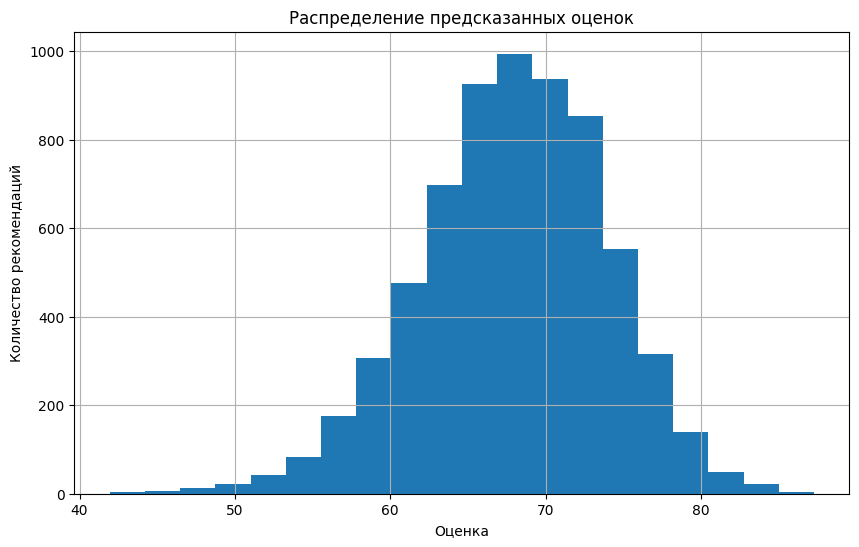

In [58]:
# Анализ распределения оценок
plt.figure(figsize=(10, 6))
recommendations_df['predicted_score'].hist(bins=20)
plt.title('Распределение предсказанных оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество рекомендаций')
plt.show()

По графику:
- Нормальное распределение: Оценки приближаются к нормальному распределению, сосредотачиваясь вокруг среднего значения. Это может указывать на то, что модель дает умеренные предсказания без чрезмерных крайностей в оценках. Данный график вообще не похож на распределение в разведовательном анализе, где было два пика по краям.
- Центр тяжести: Большинство предсказанных оценок сконцентрированы в диапазоне примерно от 50 до 70, что может свидетельствовать о том, что модель в целом не склонна к выдаче крайне высоких или низких оценок.
- Пик распределения: Пиковые значения гистограммы, кажется, находятся в районе 55-65, что предполагает наиболее часто предсказываемую оценку моделью.
- Отсутствие крайних значений: На графике видно, что мало оценок выше 70 и ниже 40, что может свидетельствовать о некотором сжатии предсказаний (отсутствие большой вариабельности).

In [59]:
# Находим топ рекомендацию для каждого сотрудника
top_recommendations_by_employee = recommendations_df.loc[recommendations_df.groupby('employee_id')['predicted_score'].idxmax()]

# Подсчет частоты встречаемости каждого курса среди топ рекомендаций
top_course_counts = top_recommendations_by_employee[['course_id','course_nm']].value_counts()

# Вывод топ-10 курсов
print("Топ-20 наиболее высоко оцененных курсов:")
print(top_course_counts.head(20))

Топ-20 наиболее высоко оцененных курсов:
course_id  course_nm                                                                
10.00      Использование технологий в клиентском обслуживании: Лучшие практики          172
43.00      Управление ожиданиями и эмоциями клиентов в условиях кризиса                 170
8.00       Развитие навыков эмпатии в клиентском обслуживании                           142
72.00      Управление ожиданиями клиентов в условиях динамичного рынка                  141
45.00      Развитие коммуникативных навыков в клиентском обслуживании                   110
20.00      Основы психологии клиентского обслуживания                                    68
51.00      Разработка персонализированных подходов к обслуживанию клиентов               56
37.00      Как преодолевать трудности в общении с трудными клиентами                     47
61.00      Управление персоналом в клиентском обслуживании: Лучшие практики              46
33.00      Профессиональный рост в области кли

**Выводы:**

- Соответствие с анализом важности курсов: В топе рекомендаций есть курсы, соответствующие самым важным направлениям, упомянутым в анализе: 
    - Коммуникативные навыки и этика: Курсы, такие как "Развитие коммуникативных навыков в клиентском обслуживании" и "Этика и профессиональное поведение в клиентском обслуживании", находятся в топе рекомендаций, что соответствует акценту на важность этих навыков в анализе.

- Профессиональное поведение и управление клиентским опытом: Курсы по управлению клиентским опытом и кризисам также присутствуют в списке, что отражает стремление улучшить взаимодействие с клиентами и управление ожиданиями.

- Тренды и новые технологии: Темы, связанные с интеграцией процессов и технологий, например, "Управление клиентским опытом: Интеграция процессов и технологий", выделяются в рекомендациях, что указывает на важность адаптации к новым трендам и технологиям в сфере обслуживания клиентов.

- Разнообразие предложений: Список топ-20 рекомендаций включает разнообразные темы, что может свидетельствовать о попытке модели обеспечить комплексный подход к обучению сотрудников, покрывающий широкий спектр компетенций.

- Недостаток персонализации: Наличие повторяющихся курсов для разных сотрудников может указывать на недостаток персонализации в рекомендациях. Это может быть связано с моделью, которая склонна предпочитать определенные курсы независимо от индивидуальных характеристик сотрудников.


В дальнейшем возможно лучше сосредоточиться на двух направлениях:
- Повышение точности предсказания рекомендаций

- Персонализация: надо попробовать поискать способы улучшения персонализации модели, чтобы удостовериться, что рекомендации соответствуют индивидуальным потребностям и интересам каждого сотрудника.

- Баланс тем: возможно надо стремиться к балансу между фундаментальными навыками и новыми технологиями, чтобы обеспечить сотрудникам комплексное и актуальное образование.